# Validate DINOv3 CHM with airborne lidar grids (LVIS): 
## Step 1: create validation CSVs
+ read CHM footprint
+ read LVIS footprint
+ find `intersection` of CHMs with LVIS
+ multiprocessing data frames to get CSVs of pred vs observed + ancillary attributes

Paul Montesano  
Jan 2026

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import folium

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib
import maplib

# This is a private repo
sys.path.append('/home/pmontesa/code/dgtools')
from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import notebooks.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotnine
from plotnine import *

import sklearn.metrics as metrics

In [2]:
fn = '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2017/output/metrics/30/LVIS2_ABoVE2017_0715_R1803_072046_RH098_mean_30m.tif'
with rasterio.open(fn) as ds:
    print(ds.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 255.0, 'width': 379, 'height': 115, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -2011950.0,
       0.0, -30.0, 3740300.0), 'blockxsize': 379, 'blockysize': 5, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [3]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

In [4]:
from multiprocessing import Pool
from functools import partial

## Setup Paths from Sept-Dec 2025 work with DinoV3

In [5]:
OUT_CHM = '4.3.2.5'
OUT_CHM_SUBSET = 'dm_10m' #'002m' # <-- this is where val CSVs will go

dir_main = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs'
#dir_chm =           f'{dir_main}/development/chm/dinov3/{OUT_CHM}'

dir_chm =           f'{dir_main}/chm/2026_chm/{OUT_CHM}/{OUT_CHM_SUBSET}'

dir_validate_main = f'{dir_main}/validation/chm/dinov3/{OUT_CHM}/{OUT_CHM_SUBSET}'
!mkdir -p $dir_validate_main

In [6]:
dir_chm

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m'

In [7]:
dir_validate_main

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m'

In [8]:
f_list = glob.glob(dir_chm + '/*.tif')
len(f_list)

3219

In [9]:
f_list[0]

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20170530_M1BS_104001002D4B4F00-chm-dm-10m.tif'

### Read the CHM footprints in (from DinoV3 CHM)

`code/above-shrubs/notebooks/footprint_predictions.ipynb`

In [10]:
nowtime = pd.Timestamp.now().strftime('%Y%m%d')
nowtime

'20260202'

In [11]:
#footprint_gdf_chm = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_chm_dinov3_4.3.2.5.gpkg') # 002m
footprint_gdf_chm = gpd.read_file('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_2026_chm_4.3.2.5_dm_10m.gpkg') # dm_10m
footprint_gdf_chm.shape

(3219, 14)

In [12]:
footprint_gdf_chm.file.to_list()[0]

'WV02_20170515_M1BS_103001006944DA00-chm-dm-10m.tif'

### Read in LVIS footprints

In [13]:
# Open the LVIS file, which has multiple layers based on year
foot_lvis_fn = os.path.join('/explore/nobackup/people/pmontesa/userfs02/arc/_footprints', 'footprints_lvis_above.gpkg')
gdf_list = []
for layername in fiona.listlayers(foot_lvis_fn):
    gdf_list.append(gpd.read_file(foot_lvis_fn, layer=layername))
foot_lvis = pd.concat(gdf_list, ignore_index=True).to_crs(4326)
foot_lvis.columns = [x.lower() for x in foot_lvis.columns]

In [14]:
foot_lvis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3579 entries, 0 to 3578
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   dn        3579 non-null   float64 
 1   file      3579 non-null   object  
 2   path      3579 non-null   object  
 3   geometry  3579 non-null   geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 112.0+ KB


In [ ]:
foot_lvis.head()

### Overlay LVIS with CHM footprints

In [18]:
%%time
foot_intersect_chm_lvis = gpd.overlay(footprint_gdf_chm[(footprint_gdf_chm.month == 7) | (footprint_gdf_chm.month == 8)], foot_lvis.to_crs(footprint_gdf_chm.crs), how='intersection')

CPU times: user 4min 8s, sys: 709 ms, total: 4min 9s
Wall time: 4min 9s


### Save the Validation Intersection Geodataframe

In [19]:
foot_intersect_chm_lvis.to_file(os.path.join(dir_validate_main, f'val_intersect_footprints_LVIS_julyaug_{nowtime}.gpkg'), driver='GPKG')

## Read the Intersection footprints back in

In [20]:
### July-Aug
foot_intersect_chm_lvis = gpd.read_file(dir_validate_main + f'/val_intersect_footprints_LVIS_julyaug_LVIS_20260202.gpkg')

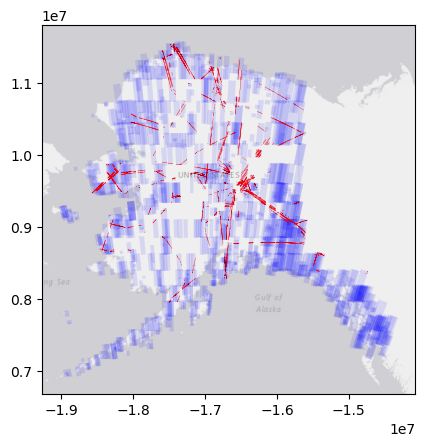

In [20]:
ax = footprint_gdf_chm[footprint_gdf_chm.month.isin([7,8])].cx[-170:-130,50:90].to_crs(3857).plot(color='blue', alpha=0.1)
ax = foot_intersect_chm_lvis.cx[-170:-130,50:90].to_crs(3857).plot(color='red', ax=ax)
ax = ctx.add_basemap(ax, crs=3857, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ' )

In [26]:
### All months
foot_intersect_chm_lvis = gpd.read_file(dir_validate_main + f'/val_intersect_footprints_LVIS_20260127.gpkg')

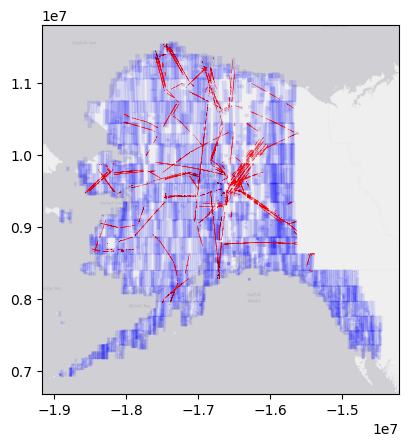

In [16]:
ax = footprint_gdf_chm.cx[-170:-130,50:90].to_crs(3857).plot(color='blue', alpha=0.1)
ax = foot_intersect_chm_lvis.cx[-170:-130,50:90].to_crs(3857).plot(color='red', ax=ax)
ax = ctx.add_basemap(ax, crs=3857, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ' )

# Get all corresponding filenames for validation
for LVIS and predictions


In [27]:
foot_intersect_chm_lvis.head()

,file_1,footprint_name,path_1,area_km2,area_ha,type,catid,sensor,year,month,date,year_cat,month_cat,dn,file_2,path_2,geometry
0,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,375.2716,37527.16,$CHM_{SR}$,103001005871E600-chm-dm-10m.tif,WV02,2016,6,2016-06-23,2016,6,1.0,LVISF2_ABoVE2019_0722_R2003_064925_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-150.40294 63.90645, -150.4025..."
1,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,375.2716,37527.16,$CHM_{SR}$,103001005871E600-chm-dm-10m.tif,WV02,2016,6,2016-06-23,2016,6,1.0,LVISF2_ABoVE2019_0722_R2003_064838_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-150.00361 63.87971, -150.0042..."
2,WV03_20190824_M1BS_1040010050A21600-chm-dm-10m...,WV03_20190824_M1BS_1040010050A21600-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,1982.1430,198214.30,$CHM_{SR}$,1040010050A21600-chm-dm-10m.tif,WV03,2019,8,2019-08-24,2019,8,1.0,LVISF2_ABoVE2019_0731_R2003_063007_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-149.97546 62.58856, -149.9741..."
3,WV03_20190824_M1BS_1040010050A21600-chm-dm-10m...,WV03_20190824_M1BS_1040010050A21600-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,1982.1430,198214.30,$CHM_{SR}$,1040010050A21600-chm-dm-10m.tif,WV03,2019,8,2019-08-24,2019,8,1.0,LVISF2_ABoVE2019_0731_R2003_063598_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-150.00431 61.83468, -150.0172..."
4,WV03_20190824_M1BS_1040010050A21600-chm-dm-10m...,WV03_20190824_M1BS_1040010050A21600-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,1982.1430,198214.30,$CHM_{SR}$,1040010050A21600-chm-dm-10m.tif,WV03,2019,8,2019-08-24,2019,8,1.0,LVISF2_ABoVE2019_0731_R2003_063352_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-150.06206 62.28483, -150.0616..."


In [28]:
# f = glob.glob(f'{dir_footprints}/footprint_overlay_lvis_*.gpkg')[0]
# lvis_pred_SUBSET = gpd.read_file(f, driver='GPKG')

### Unique set of strips for validation

In [29]:
val_strips = set(foot_intersect_chm_lvis.footprint_name.to_list())
len(val_strips)

1307

## Get matched lists of paths of predicted CHMs and reference CHMs

In [30]:
foot_intersect_chm_lvis.head(2)

,file_1,footprint_name,path_1,area_km2,area_ha,type,catid,sensor,year,month,date,year_cat,month_cat,dn,file_2,path_2,geometry
0,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,375.2716,37527.16,$CHM_{SR}$,103001005871E600-chm-dm-10m.tif,WV02,2016,6,2016-06-23,2016,6,1.0,LVISF2_ABoVE2019_0722_R2003_064925_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-150.40294 63.90645, -150.4025..."
1,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,WV02_20160623_M1BS_103001005871E600-chm-dm-10m...,/explore/nobackup/projects/above/misc/ABoVE_Sh...,375.2716,37527.16,$CHM_{SR}$,103001005871E600-chm-dm-10m.tif,WV02,2016,6,2016-06-23,2016,6,1.0,LVISF2_ABoVE2019_0722_R2003_064838_lvis_pt_cnt...,/att/nobackup/pmontesa/userfs02/data/LVIS/2019...,"MULTIPOLYGON (((-150.00361 63.87971, -150.0042..."


In [31]:
#pred_stack_list = sorted(list(set(lvis_pred_tte.file.to_list())))
foot_intersect_chm_lvis["pred_path"] = foot_intersect_chm_lvis["path_1"] + '/' + foot_intersect_chm_lvis["file_1"]

pred_path_list = foot_intersect_chm_lvis.pred_path.to_list()
pred_path_list_julyaugust = foot_intersect_chm_lvis[foot_intersect_chm_lvis.month.isin([7,8])].pred_path.to_list()

print(f'{len(list(set(pred_path_list)))} individual chm predictions from srlite available for validation.')
print(f'{len(list(set(pred_path_list_julyaugust)))} individual chm predictions from srlite in July/Aug available for validation.')

pred_path_list[0:5]

1307 individual chm predictions from srlite available for validation.
538 individual chm predictions from srlite in July/Aug available for validation.


['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160623_M1BS_103001005871E600-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160623_M1BS_103001005871E600-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190824_M1BS_1040010050A21600-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190824_M1BS_1040010050A21600-chm-dm-10m.tif',
 '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV03_20190824_M1BS_1040010050A21600-chm-dm-10m.tif']

In [32]:
foot_intersect_chm_lvis["lvis_path"] = foot_intersect_chm_lvis["path_2"].str.replace('/att/nobackup','/explore/nobackup/people') + '/' + foot_intersect_chm_lvis["file_2"]
lvis_path_list = [f.replace('lvis_pt_cnt', 'RH098_mean') for f in foot_intersect_chm_lvis.lvis_path.to_list()]
lvis_path_list_julyaugust = [f.replace('lvis_pt_cnt', 'RH098_mean') for f in foot_intersect_chm_lvis[foot_intersect_chm_lvis.month.isin([7,8])].lvis_path.to_list()]

print(f'{len(list(set(lvis_path_list)))} individual LVIS flightlines being used for validation.')
print(f'{len(list(set(lvis_path_list_julyaugust)))} individual LVIS flightlines associated with July/Aug CHMs available for validation.')

lvis_path_list[0:5]

1193 individual LVIS flightlines being used for validation.
963 individual LVIS flightlines associated with July/Aug CHMs available for validation.


['/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_064925_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_064838_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0731_R2003_063007_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0731_R2003_063598_RH098_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0731_R2003_063352_RH098_mean_30m.tif']

#### an LVIS flightline can intersect multiple CHMs

In [33]:
print(f'{len(pred_path_list)} unique intersections (predicted DINOv3 CHM X LVIS) available for validation.')
print(f'{len(pred_path_list_julyaugust)} unique intersections (predicted DINOv3 CHM for Jul/Aug X LVIS) available for validation.')

8155 unique intersections (predicted DINOv3 CHM X LVIS) available for validation.
3219 unique intersections (predicted DINOv3 CHM for Jul/Aug X LVIS) available for validation.


# Validation of stacks with LVIS
1. Use the corresponding filenams: pred_fn , lvis_fn
2. select a random set of a few stacks  
3. validate the portion of this stack that intersects with LVIS 

### Map a single random validation site

In [75]:
if True:
    # Random test
    IMG_IDX = random.sample(range(0,len(lvis_path_list)), 1)[0]
else:
    # Selected test
    IMG_IDX = [i for i,x in enumerate(lvis_path_list) if 'R1803_068540' in x][0]

print(IMG_IDX)

test_gdf = foot_intersect_chm_lvis.iloc[IMG_IDX:IMG_IDX+1].drop(columns=['date'])
test_gdf.explore(color='red', tiles=maplib.basemap_xyz_url['esri_imagery'], attr=' ', height='50%')

3023


In [19]:
import importlib
importlib.reload(notebooks.predlib)

<module 'notebooks.predlib' from '/home/pmontesa/code/above-shrubs/notebooks/predlib.py'>

### Plots for that single random validation site

In [77]:
df_test = notebooks.predlib.validate_chm_pred(pred_path_list[IMG_IDX], lvis_path_list[IMG_IDX], 'RH075', scale_factor=1, RETURN_DF=True, DST_NDV=None, DEBUG=True)

Calculating slope from DEM...
WV03_20200612_M1BS_104001005D050800-chm-dm-10m.tif
LVISF2_ABoVE2019_0731_R2003_080611_RH075_mean_30m.tif
LVISF2_ABoVE2019_0731_R2003_080611_CC_gte_01p37m_30m.tif
LVISF2_ABoVE2019_0731_R2003_080611_ZG_mean_30m.tif
LVISF2_ABoVE2019_0731_R2003_080611_lvis_pt_cnt_30m.tif
Length of warp ma list: 5
Warped ma min, max: --, --
Warped ma min, max: -0.03999999910593033, 18.196666717529297
Warped ma min, max: 17, 9165
Warped ma min, max: 0.004139414988458157, 64.58607482910156
Warped ma min, max: 1, 13
Warped ma masked min, max: --, --
Warped ma masked min, max: --, --
Warped ma masked min, max: --, --
Warped ma masked min, max: --, --
Warped ma masked min, max: --, --


### Make plots for a random number of validation sites

In [78]:
if False:
    for IMG_IDX in random.sample(range(0,len(lvis_path_list)), 1):
        print(IMG_IDX)
        #lvis_pred_SUBSET.iloc[IMG_IDX:IMG_IDX+1].explore()
        notebooks.predlib.validate_chm_pred(pred_path_list[IMG_IDX], lvis_path_list[IMG_IDX], scale_factor=1, RETURN_DF=False)

### Make plots for a specific SRlite fid

In [79]:
if True:
    df_list = []
    #dir_chm_test = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/products/test'
    #fid = 'WV02_20130721_M1BS_10300100254C6E00'
    catid = '103001005908BE00'

    # fn = f'{fid}/{fid}-sr-02m.cnn-chm-v1-local.tif'
    # pred_path_specific = os.path.join(dir_chm, fn)

    # Get index in list
    INDICES = [i for i, s in enumerate(pred_path_list) if catid in s]

    for IMG_IDX in INDICES:
        print(pred_path_list[IMG_IDX])

        # Orig pred
        df = notebooks.predlib.validate_chm_pred(pred_path_list[IMG_IDX], lvis_path_list[IMG_IDX], 'RH050',scale_factor=0.1, RETURN_DF=True, DST_NDV=0) # Using 0 as nodata value to this works with uint16 and uint8
        ## New pred
        #notebooks.predlib.validate_chm_pred(pred_path_specific, lvis_path_list[IMG_IDX], scale_factor=0.1, RETURN_DF=False)
        df_list.append(df)

/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_20160724_M1BS_103001005908BE00-chm-dm-10m.tif
/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/2026_chm/4.3.2.5/dm_10m/WV02_201607

In [80]:
df_rh050 = pd.concat(df_list)
df_rh050.shape

(188546, 5)

In [83]:
df_rh050

,ht_m_src,ht_m_ref,tcc_ref,slope_ref,cnt_ref
0,0.2,-0.121111,5.0,1.810630,18.0
1,0.1,-0.120000,1.0,1.970867,16.0
2,0.4,-0.121111,5.0,1.810630,18.0
3,0.1,-0.121111,5.0,1.810630,18.0
4,0.7,-0.126000,1.0,0.708694,20.0
...,...,...,...,...,...
20,1.5,-0.208000,27.0,0.420825,5.0
21,1.6,-0.208000,27.0,0.420825,5.0
22,1.4,-0.247500,33.0,0.572358,8.0
23,0.9,-0.234286,23.0,0.344383,7.0


# Build validation table

In [20]:
lvis_path_list[0]

'/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_064925_RH098_mean_30m.tif'

In [21]:
TEST = False

## Validation subdir - RH specific

### Change the LVIS RH metric for validation

In [43]:
SELECT_LVIS_RH = 'RH075' #< - this will be replaced with RH from SELECTED_LVIS_RH_LIST
lvis_path_list_SELECT = [p.replace('RH098', SELECT_LVIS_RH) for p in lvis_path_list]
lvis_path_list_SELECT[0:5]

['/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_064925_RH075_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0722_R2003_064838_RH075_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0731_R2003_063007_RH075_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0731_R2003_063598_RH075_mean_30m.tif',
 '/explore/nobackup/people/pmontesa/userfs02/data/LVIS/2019/output/metrics/30/LVISF2_ABoVE2019_0731_R2003_063352_RH075_mean_30m.tif']

In [45]:
LVIS_PATH_INDEX_LIST_TEST = random.sample( list(range(0,len(lvis_path_list_SELECT))) , 1)
LVIS_PATH_INDEX_LIST = list(range(0,len(lvis_path_list_SELECT)))
len(LVIS_PATH_INDEX_LIST)

8155

In [32]:
# SELECTED_LVIS_RH_LIST = ['RH050','RH075','RH098']
SELECTED_LVIS_RH_LIST = ['RH075','RH085','RH098']

#RH_string_list = SELECTED_LVIS_RH_LIST
# for RH_string in RH_string_list:

#     # Set the path of the specific reference RH metric tif
#     list_of_ref_fn_SELECT = [p.replace('RH098', RH_string) for p in lvis_path_list]
#     print(list_of_ref_fn_SELECT[0:2])

In [33]:
# Output dir for prediction csv files
##dir_pred_csv = os.path.join(dir_main, f'validate_{OUT_SUBDIR}_LVIS{SELECT_LVIS_RH}')
dir_val_csv = os.path.join(dir_validate_main, 'LVIS'+'_'.join(SELECTED_LVIS_RH_LIST))
!mkdir -p $dir_val_csv
dir_val_csv

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/LVISRH075_RH085_RH098'

In [34]:
import importlib
importlib.reload(footprintlib)
importlib.reload(notebooks.predlib)

<module 'notebooks.predlib' from '/home/pmontesa/code/above-shrubs/notebooks/predlib.py'>

In [35]:
if TEST:
    DF_VAL_LIST = []

    for IMG_IDX in LVIS_PATH_INDEX_LIST:
        # Writes a csv
        df_test = notebooks.predlib.do_validation_df(IMG_IDX, pred_path_list_julyaugust, lvis_path_list_julyaugust, SELECTED_LVIS_RH_LIST, out_csv_dir=dir_val_csv, DEBUG=True, RETURN_DF=True)


In [37]:
dir_val_csv

'/explore/nobackup/projects/above/misc/ABoVE_Shrubs/validation/chm/dinov3/4.3.2.5/dm_10m/LVISRH075_RH085_RH098'

In [38]:
len(pred_path_list_julyaugust)

3219

In [39]:
len(lvis_path_list_julyaugust)

3219

### Multiprocess all validation CSVs

In [48]:
%%time
with Pool(processes=15) as pool:
    pool.map(partial(notebooks.predlib.do_validation_df,
                     
                     # All months
                     #list_of_pred_fn=pred_path_list,  
                     #list_of_ref_fn=lvis_path_list,
                     
                     # July/Aug only
                     list_of_pred_fn=pred_path_list_julyaugust, 
                     list_of_ref_fn=lvis_path_list_julyaugust,
                     
                     RH_string_list=SELECTED_LVIS_RH_LIST, 
                     out_csv_dir=dir_val_csv
                    ), 
             #list(reversed(LVIS_PATH_INDEX_LIST)) 
             LVIS_PATH_INDEX_LIST 
            )

CPU times: user 203 ms, sys: 363 ms, total: 566 ms
Wall time: 16min 20s


TypeError: Cannot convert fill_value 65536.0 to dtype uint16

### Read in all validation CSVs

In [275]:
%%time
if False:
    with Pool(processes=10) as pool:
        DF_VAL_LIST = pool.map(partial(pd.read_csv), glob.glob(dir_val_csv + '/*.csv') )
else:
    DF_VAL_LIST = [pd.read_csv(f) for f in glob.glob(dir_val_csv + '/*.csv')]
df_val = pd.concat(DF_VAL_LIST)
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223092343 entries, 0 to 11203
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ht_m_src        float64
 1   ht_m_ref_RH050  float64
 2   ht_m_ref_RH075  float64
 3   ht_m_ref_RH098  float64
 4   tcc_ref         float64
 5   tcc_class       object 
 6   file            object 
 7   date            object 
 8   type            object 
 9   footprint_name  object 
 10  catid           object 
 11  sensor          object 
 12  year            int64  
 13  month           int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 24.9+ GB
CPU times: user 6min 39s, sys: 1min 36s, total: 8min 16s
Wall time: 9min 13s


In [261]:
df_val.tail()

,ht_m_src,ht_m_ref_RH050,ht_m_ref_RH075,ht_m_ref_RH098,tcc_ref,tcc_class,file,date,type,footprint_name,catid,sensor,year,month
430477,0.0,-0.23,0.066,0.632,25.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430478,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430479,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430480,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8
430481,0.0,-0.22,0.070,0.595,26.0,0-20%,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,2019-08-17,CHM pred,WV03_20190817_M1BS_1040010051769700-chm-dm-10m...,1040010051769700-chm-dm-10m.tif,WV03,2019,8


# Find useful predictions
## Join VHR metadata
this can also be used at the front-end to reduce the set of candidate strips used for predictions

In [20]:
vhr_df.head()

,satid,catid,tlctime,gsd,sunaz,sunel,az,el,intrack,crosstrack,...,ULHAE,URLON,URLAT,URHAE,LLLON,LLLAT,LLHAE,LRLON,LRLAT,LRHAE
0,WV02,1030010005C35F00,2010-07-26 20:20:34.983650+00:00,2.037500,167.4500,53.5625,217.550,70.35,-15.9750,-6.5250,...,520.5,-131.255904,56.031801,520.5,-131.545886,54.949529,520.5,-131.267842,54.957316,520.5
0,WV02,103001000BA1E500,2011-06-07 20:16:59.117856+00:00,2.006875,169.7625,58.2250,205.225,83.20,-5.6625,-1.0625,...,377.0,-130.255637,55.025096,377.0,-130.519542,53.947426,377.0,-130.266322,53.947525,377.0
0,WV02,1030010024338600,2013-07-07 20:09:48.553950+00:00,1.937400,166.5000,55.6300,98.450,77.22,1.0200,10.5300,...,1177.0,-129.236653,57.024840,1177.0,-129.508432,55.966950,1177.0,-129.233129,55.971002,1177.0
0,WV02,103001002503EF00,2013-07-14 20:50:53.405450+00:00,2.241100,180.1800,55.2500,301.890,61.63,4.9600,-24.7000,...,1112.0,-131.004100,57.028261,1112.0,-131.318459,55.977952,1112.0,-130.988824,55.956400,1112.0
0,WV02,10300100252F2900,2013-07-14 20:51:22.302150+00:00,2.207500,179.8000,55.1900,282.630,62.59,-2.9200,-23.8100,...,1203.0,-131.298624,57.025459,1203.0,-131.609755,55.975876,1203.0,-131.283463,55.958652,1203.0


In [ ]:
%%time
df_val_meta = pd.merge(df_val, vhr_df, how='left', left_on = 'catid', right_on = 'catid').drop(columns=['Unnamed: 0'])
df_val_meta.head()

## Join SRlite metrics 
##### See SRlite metrics analysis (example): `code/geoscitools/srlite_metrics.ipynb` 
- use this to filter validation & to inform training chip selection so you dont train with chips from bad data  
- develop this for Alaska in `code/geoscitools/above_shrubs_model_plan.ipynb`

### The list of srlite ids for validation (have sizable intersections with LVIS)

In [47]:
g = df_val.groupby('footprint_name')
PRED_FILE_LIST = list(g.groups.keys())
print(len(PRED_FILE_LIST))
PRED_FILE_LIST[0:5]

25


['WV02_20100709_M1BS_1030010006AC3100',
 'WV02_20100820_M1BS_1030010006A83500',
 'WV02_20110707_M1BS_103001000C6D7600',
 'WV02_20110707_M1BS_103001000CA39000',
 'WV02_20110804_M1BS_103001000C140300']

In [132]:
# Save this list to CSV for applying the predictions
import csv
PRED_FILE_LIST_FN = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/list_predstack_file_id_for_val_v01.csv'
df = pd.DataFrame(PRED_FILE_LIST, columns=["file_id"])
df.to_csv(PRED_FILE_LIST_FN, index=False)

In [120]:
from sklearn.linear_model import LinearRegression

In [ ]:
def model(df):
    
    X = df['ht_m_ref'].values
    Y = df['ht_m_src'].values
    
    return np.squeeze(LinearRegression().fit(X, Y))#.predict(delta))

df_val.groupby(['tcc_class','year']).apply(model)